В этом задании необходимо создать и обучить алгоритм REINFORCE на среде `Pong-v4`. Обратите внимание, что эта среда немного отличается от среды, которая демонстрировалась в лекции (`PongDeterministic-v4`) - но вся логика алгоритма, которая описывается в лекции, остается действительной.

Можно использовать шаблон лекционного ноутбука, но советуется писать код самому.

______________________________________________________________________

Скачиваем нужные файлы для библиотеки gym.

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

     |████████████████████████████████| 1.6MB 31.6MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656449 sha256=18f0ef20bdedc1c85c99e6fc2ca58236112ff6a0f1575d103df98fe4ff8eae24
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 2.8MB 32.7MB/s 
  Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


Импортируем все нужные модули и библиотеки, подключаемся к диску.

In [ ]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Model, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**В этом блоке заключается единственная разница от кода ноутбука: мы подгружаем другую среду из библиотеки gym (`Pong-v4`).**

In [ ]:
env = gym.make('Pong-v4')                              # Создаем среду Pong (эта версия немного сложнее, чем PongDeterministic)
new_frame = env.reset()                                # Запускаем среду (это действие возвращает начальное состояние)
print(f"Размерность состояния: {new_frame.shape}")     # Взглянем на размерность состояния

Размерность состояния: (210, 160, 3)


In [ ]:
env.unwrapped.get_action_meanings() #Взглянем на все возможные действия, и узнаем что они делают.

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

Получается, что у нас действия:

0 - Noop (ничего не делать)

1 - Fire (запускать мячь)

2 - Right - (двигать вправо)

3 - Left - (двигать влево)

4 - Rightfire - (двигать вправо и запускать мячь)

5 - Leftfire - (двигать влево и запускать мячь)

По скольку конкретная игра создана под платформу atari, в ней 6 разных действий, но некоторые из них фактический делают то же самое (например, Right и Rightfire). По этому, есть смысл не давать агенту использовать все действия, а создать список из действий которые можно использовать.

In [ ]:
action_space = [0, 2, 3] #Создаем массив возможных действий. Агент может стоять на месте, двигаться влево, или двигаться вправо.
num_actions = len(action_space) #Записываем в переменную количество уникальных возможных действий - также известно как размерность пространства действий.

Далее, мы используем pyplot чтобы посмотреть на различные кадры, которые мы получаем из среды. 

Для этого мы подадим 20 рандомных действий в среду, и взглянем на каждый кадр который получается после каждого действия. Это даст нам понятия о том, как выглядет игровой процесс.

Логика взаимодейстий с gym играми происходит следующим образом:

Мы подаем действие на вход, в виде скалярного значения (в примере ниже, это действие выбирается рандомно из всех возможных действий которые определяются выше)

На выходе мы получаем: 


  1. new_frame - новый кадр.
  2. reward - награда (автоматический назначается средой, в данном случае награда +1 означает забитие гола врагу, награда -1 означает агенту забили гол.
  3. done - булевое значение, говорит если игра закончилась.
  4. misc - прочая информация о игровой среде (редко используется).

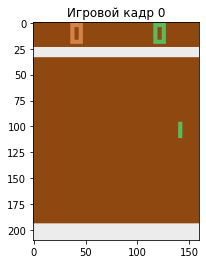

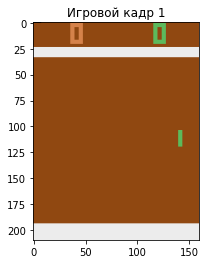

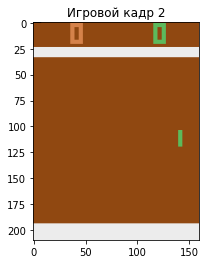

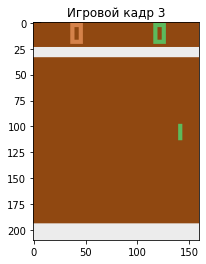

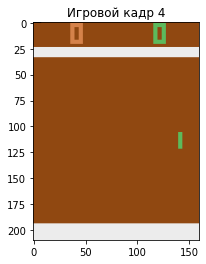

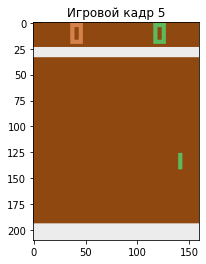

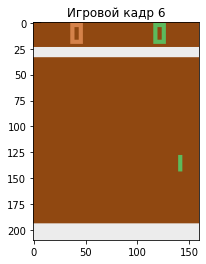

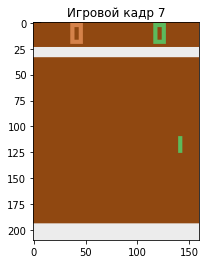

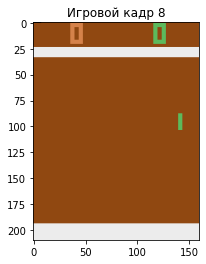

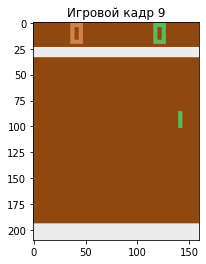

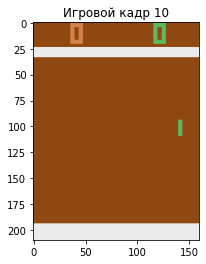

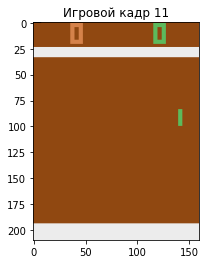

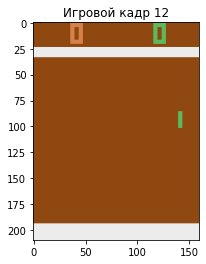

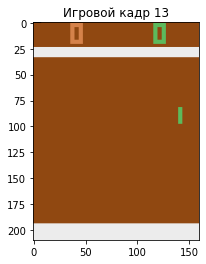

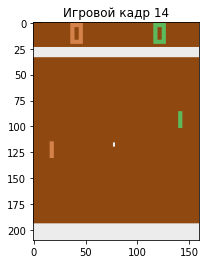

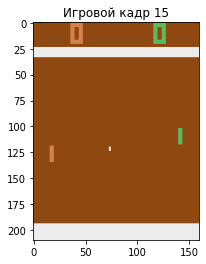

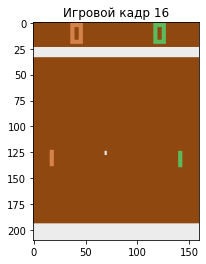

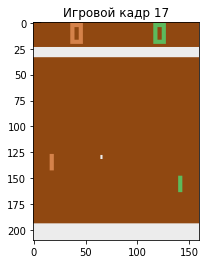

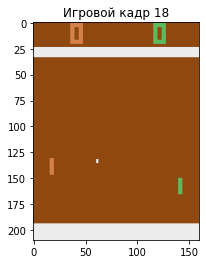

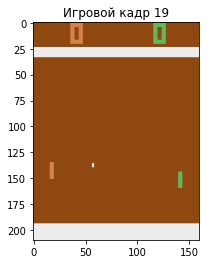

In [ ]:
env.reset()         #Начинаем новую игру
for i in range(20): #Запускаем цикл 20 раз
  new_frame, reward, done, misc = env.step(np.random.choice(action_space)) #Подаем рандомное действие на вход. На выходе получаем новую информацию о текущем состоянии игры.
  plt.imshow(new_frame)                           # 'Рисуем' изображения
  plt.title(f"Игровой кадр {i}", fontsize = 12)   # Добавляем заголовок
  plt.show()                                      # Показываем изображения

## Предобработка состояний среды

Посмотрев на игровой кадр выше, можно заметить что катринка содержит много "лишней" информации - цвет, баллы, границы, и тд. Крайней желательно предобработать данные, чтобы убрать эту информацию.

Также, отсутствует некая критический важная информация - направление и скорость движения мяча, а также обеих игроков. Мы не можем знать эту информацию из одного, неподвижного кадра. Чтобы добавить эту информацию, мы "склеим" два последовательных кадра вместе через конкатенацию.

*Примечание: возможно, что на картинке выже не видно мяча или второго игрока. Это потому что они появляются не на первом кадре игры, а где-то на 10-ом.*

In [ ]:
#Создадим функцию для предобработки кадра - превращает цвет в чёрно-белый, отсекает ненужные части кадра, и сжимает.
def preprocess_frame(frame):       #Функция принимает кадр на вход
  frame = frame.astype(np.float32) #Меняем тип данных на float32

  frame = frame[35:195]            #Отсекаем ненужные части кадра, которые не пренадлежат игровому полю.
  frame = frame[::2, ::2, 0]       #Сжимаем изображение (берём каждый второй пиксель)

  frame[frame == 144] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame == 109] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame != 0] = 1            #Всё, что не пренадлежит фону, меняем на белый цвет (значение пикселя = 1)
  return frame.reshape(80, 80, 1)  #Меняем форму итогового кадра на (80, 80, 1)

#Создадим функцию для "склеивание" двух кадров - этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.
def stack_frames(new_frame, old_frame):                    #Функция принимает два изображения на вход: новое и старое                   
  new_frame = preprocess_frame(new_frame)                  #Предобрабатываем новое изображение (используем выше объявленную функцию)
  old_frame = preprocess_frame(old_frame)                  #Предобрабатываем старое изображение (используем выше объявленную функцию)
  return np.concatenate([new_frame, old_frame], axis = -1) #Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

##Создаем нейронную сеть

Сеть принимает на вход состояние с размерностью (80, 80, 2). На выходе будет слой с 3 нейронами (т.к. у нас 3 возможных действия), в которых будет содержаться вероятность принятия каждого действия.

In [ ]:
def create_model():                      #Объявляем функцию которая создает модель
  input = Input((80, 80, 2))             #Задаем входную размерность - (80, 80, 2)
  x = Flatten()(input)                   #Применяем выравнивающий слой
  x = Dense(1024, activation = 'elu')(x) #Полновсязанный слой - империческим методом выявлено что с активационной функции 'elu' сеть обучается лучше.
  x = Dense(512, activation = 'elu')(x)  #Полновсязанный слой - империческим методом выявлено что с активационной функции 'elu' сеть обучается лучше.
  output = Dense(num_actions, activation = 'softmax')(x) #Выходной слой, где считаются вероятности классификации нужного действия.

  model = Model(input, output)   #Создаем модель
  model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') #Компилируем модель - используем оптимизатор RMSprop с низким шагом обучения.
  return model   #Возвращаем созданную модель

##Создадим функцию для выбора действия

Нейронная сеть выдает вероятности принятия каждого действия - ниже созданная функция использует эти вероятности для выбора конкретного действия.

In [ ]:
def choose_action(state):      #Создаем функцию для выбора действия
  probs = model.predict(state.reshape(1, 80, 80, 2))                    #Делаем предикт модели
  action_index = np.random.choice(num_actions, p = probs.flatten())     #Выбриаем индекс действия рандомно, используя предсказанные вероятности модели
  return action_index     #Возвращаем индекс рандомно выбранного действия (в игровом цикле мы будем обращаться к самому действию через этот индекс).

##Создадим функции для предобработки наград

В теоретической части занятия упомяналось, что нам необходимо предобрабатывать награды чтобы алгоритм мог корректно обучаться. В данном случае, у нас скудные награды, но мы должны предобработать эти награды чтобы какая-то награда назначалось за каждое действие.

In [ ]:
#Создадим функцию для предобработки наград
def preprocess_rewards(rewards_list):
  discounted_rewards = np.zeros_like(rewards_list)      #Инициализируем массив обработанных наград нулями
  running_add = 0                                       #running_add содержит предобработанную награду, которая назначается за действие - инициализируется нулем.
  for i in reversed(range(len(discounted_rewards))):    #Итерируем через массив наград в обратном порядке.
    if rewards_list[i] != 0:                            #Если на заданный момент есть не-нулевая награда, которая была назначена средой: 
      running_add = 0                                   #переменная running_add обнуляется.
    running_add = gamma * running_add + rewards_list[i] #Задаем награду за текущее действие (псевдо-уравнение Беллмена).
    discounted_rewards[i] = running_add                 #Записываем награду в массив обработанных наград
  return discounted_rewards                  #Возвращаем массив обработанных наград

#Создадим функцию для визуализации качества работы агента

Ниже созданная функция рисует график, где отображается суммарная награда и длительность каждого эпизода. Длительность эпизода измеряется количеством состояний и действий за эпизод. 

Из-за многих рандомных факторов в среде и в самом алгоритме, награда и длина эпизода будет сильно варьировать при обучении, что приведёт к сложностям при нахождении какой-либо тенденции. По этому, мы также будем считать скользящее среднее от награды и длины эпизода. Эти значения будут использоваться в качестве метрики, с помощью которых мы можем получить понятие, с какой скоростью и на сколько хорошо обучается алгоритм.

Для подсчета скользящего среднего, используется функция свёртки.

In [ ]:
#Дальше, создаем функцию для отображения наград за эпизод. По сколько здесь будут только отображаться награды, мы можем отобразить все данные на одном полотне.
def show_scores(scores, episode_durations):
  output.clear() #Удаляем предидущий вывод ячейки
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))                            #Устанавливаем большой размер полотна
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')          #Отрисовываем награды
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды')   #Считаем и отрисовываем скользящее среднее от награды
  axes[0].set_xlabel('Эпизод', fontsize = 12)                                  #Добавляем лейблы осей
  axes[0].set_ylabel('Награда', fontsize = 12)
  axes[0].legend()         #Создаем легенду

  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')  #Отрисовываем длину эпизодов
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')     #Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            #Добавляем лейблы осей
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  axes[1].legend()         #Создаем легенду

  plt.show()               #Выводим график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 20 значений.
def moving_average(data, width = 20): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

##Создаем функцию обучения модели

Логика обучения модели выглядет следующим образом: 

Внутри игрового цикла, модель принимает состояния на вход и предсказывает действия (сначала предсказывает вероятности действий, затем рандомным образом выбирает итоговое действие).

Для обновления весов, модель принимает те же состояния на вход, и предсказывает те же вероятности для принятия каждого действия. Если бы на этом заканчивался код, модель бы пыталась предсказывать все те же самые действия, которые были приняты в игре.

Вместо этого мы добавляем аргумент sample_weight. sample_weight позволяет считать значение ошибки таким образом, чтобы некоторые примеры имели наибольшое влияние на подсчет значения ошибки, чем другие. Обычно, это используется чтобы бороться с разбалансированным датасетом.

Значения которые подаются в sample_weight также могут быть отрициательными, в котором случае ошибка и её градиент будут инвертированны в отрициательное - и при обучении модель будет стримиться НЕ предсказывать ответ в y_train. Это значит, что после обновления весов, вероятность выбора действия в y_train будет ниже а вероятности выбора всех остальных действий будут выше.

В данном алгоритме, в sample_weight подается массив всех наград, которые были получены в игровом эпизоде. В итоге, если действие привело к положительной награде в будующем (т.е. текущее значение предобработанной награды - положительное), модель будет стримиться предсказывать те же действия, которые она приняла в игровом эпизоде.

Если же действие привело к отрициательной награде в будующем (т.е. текущее значение предобработанной награды - отрициательное), модель будет стремиться предсказывать другие действия. Обновление весов произойдёт таким образом, что вероятность выбора этого действия в будующем будет выше, а вероятности выбора всех остальных действий будут ниже.

Таким образом, политика меняется при обучении алгоритма. После какого-то времени, этот алгоритм сойдётся на хорошей политике, но он вряд ли сойдётся на оптимальной политике.

**Важно**: Функция ошибки в градиентной политике должна быть интегралом -1 х (все действия х награды за соответствующие действия). 

Это можно доказать интуицией следующим образом: представьте, что есть действие за которое назначается нулевая награда. Мы знаем, что после предобработки всего массива наград, данная награда не будет нулевой - она либо будет положительной, либо отрициательной. 

Однако, в обучении с подкреплением у нас есть **Марковское свойство**, что значит мы только знаем что происходит на текущий момент времени. Это значит что нейронная сеть будет получать подобные состояния при обучении, и у некоторых состояний будет положительная награда, а у некоторых - отрициательная. При использовании model.fit() в обучении, нейронная сеть будет видить только пакеты из радномно выбранных сэмплов для обучения, и у неё физический не будет достаточной информацией чтобы понять почему некоторые сэмплы имеют отрициательную награду, а некоторые - положительную. **По этому, для корректной реализации алгоритма нужно использовать .train_on_batch() для обучения алгоритма.**

In [ ]:
model = create_model() #Создаем модель используя ранее объявленную функцию

#Создаем функцию для обучения модели.
def train_model(episode_states, episode_actions, episode_rewards):
  rewards = preprocess_rewards(episode_rewards)                                  #Предобрабатываем награды используя ранее объявленную функцию
  model.train_on_batch(episode_states, episode_actions, sample_weight = rewards) #Обучаем алгоритм на собранном пакете данных - одном полном эпизоде

До того как vs начнем обучать алгоритм, нам осталось задать гиперпараметры. Также, если алгоритм уже обучался и мы хотим продолжить обучение, мы загрузим предидущую статистику и веса сохраненной модели.

В данной реализации алгоритма есть всего один гиперпараметр - гамма.

In [ ]:
gamma = 0.98 #Гимерпараметр гамма нужно назначать с учётом скудности среды и игрового процесса. Практика показывает что для этой среды, 0.98 это хорошое значение.

#Если переменная load_pretrained равна True, мы загружаем веса обученной модели и историю наград, и продолжаем обучения. 
#Если она равна False, мы начинаем обучения с нуля.
load_pretrained = False

if load_pretrained:                                                                              #Если load_pretrained равна True:
  with open('/content/drive/My Drive/pretrained_networks/reinforce_pong/scores.txt', 'rb') as f: #Открываем файл используя функцию из pickle
    all_scores, all_episode_durations, episode_number = pickle.load(f)   #Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов, и номер эпизода)
  model.load_weights('/content/drive/My Drive/pretrained_networks/reinforce_pong/REINFORCE.h5')  #Загружаем сохранённые веса
else:                     #Иначе, мы инициализируем переменную за номер эпизода нулем.
  episode_number = 0
  all_scores = []                     #Инициализируем список где будем хранить все награды (будет отображаться в качестве метрики)
  all_episode_durations = []          #Инициализируем список где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)

##Создаем игровой цикл и обучаем в нём агента



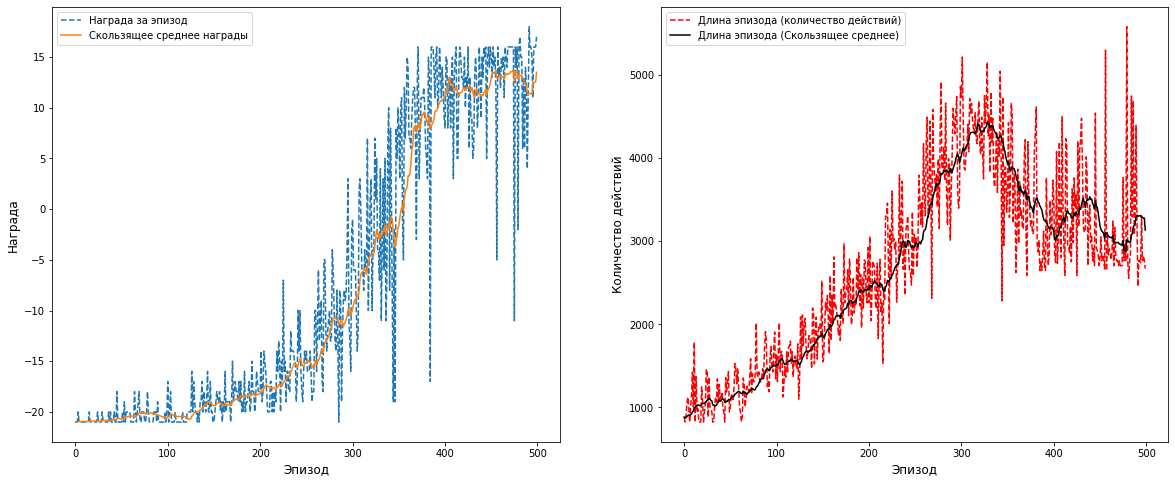

Закончен 500-й эпизод, счёт: (агент) 21 - 4 (противник), продолжительность игры: 2670 кадров.


KeyboardInterrupt: ignored

In [ ]:
env = gym.make('PongDeterministic-v4')     #Создаем среду Pong
while True:
  episode_states = []         #Создаем список где будут храниться все состояния одного эпизода (используется для обучения алгоритма)
  episode_actions = []        #Создаем список где будут храниться все действия за эпизод (используется для обучения алгоритма)
  episode_rewards = []        #Создаем список где будут храниться все награды за эпизод (используется для обучения алгоритма)

  new_frame = env.reset()          #Запускаем среду (это действие возвращает начальное состояние)
  old_frame = new_frame            #Инициализируем предидущий кадр как текущий кадр

  state = stack_frames(new_frame, old_frame) #Конкатенируем два кадра вместе чтобы создать состояние

  done = False               #Done - переменная говорит, если игровой эпизод завершён. Инициализируется с значением False.
  while not done:            #Пока игровой эпизод не завершён:
    action_index = choose_action(state)                                     #Выбираем новое действие по текущему состоянию среды
    new_frame, reward, done, misc = env.step(action_space[action_index])    #Подаем действие в среду, получаем новый кадр, награду, и узнаем если игра окончена.

    episode_states.append(state)                     #Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод.
    episode_actions.append(action_index)             #Добавляем действие в массив действий за эпизод.
    episode_rewards.append(reward)                   #Добавляем полученную награду в массив наград за эпизод.
    state = stack_frames(new_frame, old_frame)       #Создаем новое состояния, используя новый кадр (это нужно делать после добавление состояния в массив)

    old_frame = new_frame            #Устанавливаем старый кадр как новый кадр (таким образом запонимаем старый кадр)

  episode_number += 1                     #Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_timesteps = len(episode_states) #Длина эпизода (количество кадров в эпизоде) равно количеству состояний за эпизод.

  episode_states, episode_actions, episode_rewards = np.array(episode_states), np.array(episode_actions), np.array(episode_rewards) #Переводим данные в numpy массивы
  points_won = episode_rewards[episode_rewards > 0].size   #Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_lost = episode_rewards[episode_rewards < 0].size  #Считаем количество отрициательных наград (равно количеству голов, который пропустил агент)

  train_model(episode_states, episode_actions, episode_rewards) #Обучаем модель, используя состояния в эпизоде, соответствующие действия, и награды.

  episode_score = points_won - points_lost         #Очки за эпизод = количество забитых голов - количество пропущенных голов
  all_scores.append(episode_score)                 #Добавляем количество очков в список (используется в качестве метрики)
  all_episode_durations.append(episode_timesteps)  #Добавляем длину эпизода в список (используется в качестве метрики)

  show_scores(all_scores, all_episode_durations)   #Отображаем метрики на графике

  if episode_number % 10 == 0:    #Сохраняем прогресс раз в 10 эпизодов
    model.save_weights('/content/drive/My Drive/pretrained_networks/reinforce_pong/REINFORCE.h5')   #Сохраняем веса модели
    with open('/content/drive/My Drive/pretrained_networks/reinforce_pong/scores.txt', 'wb') as f:  #Открываем файл используя функцию из pickle
      pickle.dump([all_scores, all_episode_durations, episode_number], f)    #Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл

  #Дополнительно выводим статистику за эпизод через print.
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won} - {points_lost} (противник), продолжительность игры: {episode_timesteps} кадров.")